In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np
from scipy import stats
import seaborn as sns

predict = pd.read_csv('result/GAT_predicted_data.csv');
predict = predict.rename(columns={predict.columns[0]: 'id_key'})

clinical_data = pd.read_csv('data/clinical/Human__TCGA_BRCA__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi', sep='\t')
clinical_data = clinical_data.set_index('attrib_name')
clinical_data = clinical_data.transpose()
clinical_data = clinical_data.reset_index().rename(columns={'index': 'patient_id'})

clinical_data['id_key'] = clinical_data['patient_id'].str.replace('.', '-', regex=False).replace('^TCGA\\-', '', regex=True)

result = pd.merge(predict, clinical_data, on='id_key', how='left')

print(result.columns)

Index(['id_key', 'predict_label', 'patient_id', 'years_to_birth',
       'Tumor_purity', 'pathologic_stage', 'pathology_T_stage',
       'pathology_N_stage', 'pathology_M_stage', 'histological_type',
       'number_of_lymph_nodes', 'PAM50', 'ER.Status', 'PR.Status',
       'HER2.Status', 'gender', 'radiation_therapy', 'race', 'ethnicity',
       'Median_overall_survival', 'overall_survival', 'status',
       'overallsurvival'],
      dtype='object')


In [14]:
print(result.columns)

Index(['id_key', 'predict_label', 'patient_id', 'years_to_birth',
       'Tumor_purity', 'pathologic_stage', 'pathology_T_stage',
       'pathology_N_stage', 'pathology_M_stage', 'histological_type',
       'number_of_lymph_nodes', 'PAM50', 'ER.Status', 'PR.Status',
       'HER2.Status', 'gender', 'radiation_therapy', 'race', 'ethnicity',
       'Median_overall_survival', 'overall_survival', 'status',
       'overallsurvival'],
      dtype='object')


In [16]:

# Convert categorical variables to numeric where needed
result['years_to_birth'] = pd.to_numeric(result['years_to_birth'], errors='coerce')
result['number_of_lymph_nodes'] = pd.to_numeric(result['number_of_lymph_nodes'], errors='coerce')

# Function to calculate p-values for different types of variables
def calculate_p_value(subtype, clinical_var):
    if clinical_var in ['years_to_birth', 'number_of_lymph_nodes']:
        # For continuous variables, use ANOVA
        groups = [group for _, group in result.groupby('predict_label')[clinical_var]]
        return stats.f_oneway(*groups)[1]
    else:
        # For categorical variables, use Chi-square test
        contingency = pd.crosstab(result['predict_label'], result[clinical_var])
        return stats.chi2_contingency(contingency)[1]

# List of clinical parameters to analyze
clinical_params = [
    'years_to_birth',  # age
    'gender',
    "Tumor_purity",
    "pathologic_stage",
    "pathology_T_stage",
    "pathology_N_stage",
    "pathology_M_stage",
    "histological_type",
    "number_of_lymph_nodes",
    "ER.Status",
    "PR.Status",
    "HER2.Status",
]

p_values = {}
log_p_values = {}
significant_params = []

for param in clinical_params:
    p_val = calculate_p_value('predict_label', param)
    p_values[param] = p_val
    log_p_values[param] = -np.log10(p_val)
    if p_val < 0.05:
        significant_params.append(param)


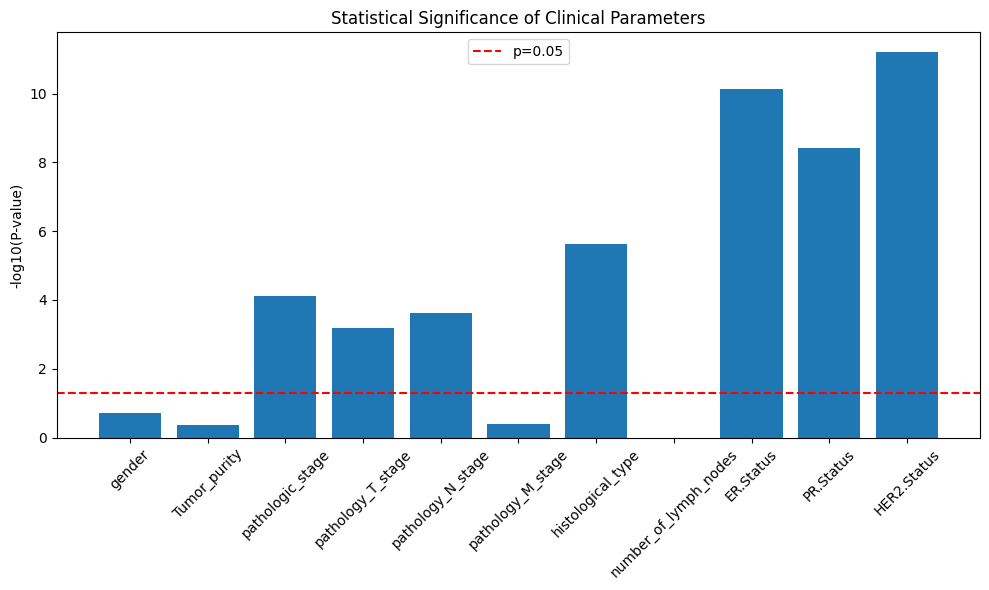

In [5]:

# Plot -log10 P-values
plt.figure(figsize=(10, 6))
plt.bar(log_p_values.keys(), log_p_values.values())
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
plt.xticks(rotation=45)
plt.ylabel('-log10(P-value)')
plt.title('Statistical Significance of Clinical Parameters')
plt.legend()
plt.tight_layout()
plt.show()



---

## 📊 Đánh giá biểu đồ: **Statistical Significance of Clinical Parameters**

Biểu đồ cột thể hiện **mức độ ý nghĩa thống kê** của các tham số lâm sàng trong việc **phân biệt các nhóm phân cụm (Predict Labels)**, sử dụng giá trị `-log10(P-value)` từ các phép kiểm định thống kê (thường là ANOVA hoặc Kruskal-Wallis).

---

### 🧠 Ý nghĩa biểu đồ:

* **Trục Y**: `-log10(P-value)`

  * Càng cao → P-value càng nhỏ → **khác biệt càng có ý nghĩa thống kê**
  * **Ngưỡng ý nghĩa thống kê p = 0.05** tương đương `-log10(0.05) ≈ 1.3` (đường đỏ đứt đoạn)

* **Trục X**: Các tham số lâm sàng như:

  * `gender`, `tumor_purity`, `pathologic_stage`, `histological_type`, `ER_status`, v.v.

---

### 📌 Nhận xét chi tiết theo từng nhóm:

| Clinical Parameter           | `-log10(P-value)` | Ý nghĩa                  |
| ---------------------------- | ----------------- | ------------------------ |
| **HER2\_Status**             | > 10              | Rất có ý nghĩa phân nhóm |
| **ER\_Status**               | ≈ 10              | Rất có ý nghĩa           |
| **PR\_Status**               | ≈ 8               | Có ý nghĩa mạnh          |
| **number\_of\_lymph\_nodes** | ≈ 5               | Có ý nghĩa tương đối     |
| **histological\_type**       | ≈ 4               | Có ý nghĩa               |
| **pathologic\_M\_stage**     | < 1               | Không có ý nghĩa         |
| **gender**, `tumor_purity`   | < 1               | Không có ý nghĩa         |

---

### ✅ Kết luận:

* **Các thông số lâm sàng như HER2, ER, PR status** có sự khác biệt **rất rõ rệt** giữa các nhóm phân cụm → đây là dấu hiệu rất tích cực, cho thấy:

  * Mô hình clustering đã tạo ra **các nhóm có liên kết sinh học lâm sàng rõ ràng**, không phải phân cụm ngẫu nhiên.
* Các thông số như **gender**, **M stage**, hoặc **tumor purity** **không giúp phân biệt rõ** các nhóm → có thể bị loại bỏ trong phân tích sâu hơn.

---

### 🧬 Ý nghĩa ứng dụng:

* Những chỉ số lâm sàng có ý nghĩa thống kê cao có thể được dùng để **giải thích đặc điểm sinh học của từng cluster**, từ đó hỗ trợ:

  * Phân loại bệnh,
  * Xây dựng mô hình chẩn đoán hoặc tiên lượng,
  * Gợi ý chiến lược điều trị chính xác (precision oncology).

---



In [17]:

# Print results
print("\nNumber of significant clinical parameters:", len(significant_params))
print("\nSignificant parameters:", significant_params)
print("\nP-values for each parameter:")
for param, p_val in p_values.items():
    print(f"{param}: {p_val:.2e}")

# Analyze relationships between subtypes and clinical features
print("\nSubtype Analysis:")
for param in clinical_params:
    if param in ['years_to_birth', 'number_of_lymph_nodes']:
        print(f"\n{param} by subtype:")
        print(result.groupby('predict_label')[param].describe())
    else:
        print(f"\n{param} distribution by subtype:")
        print(pd.crosstab(result['predict_label'], result[param]))

# Save results to CSV
result.to_csv('clinical_analysis_results.csv', index=False)



Number of significant clinical parameters: 8

Significant parameters: ['gender', 'pathologic_stage', 'pathology_T_stage', 'pathology_N_stage', 'histological_type', 'ER.Status', 'PR.Status', 'HER2.Status']

P-values for each parameter:
years_to_birth: nan
gender: 1.49e-02
Tumor_purity: 6.23e-01
pathologic_stage: 2.58e-05
pathology_T_stage: 6.06e-04
pathology_N_stage: 1.42e-03
pathology_M_stage: 4.44e-01
histological_type: 4.58e-06
number_of_lymph_nodes: nan
ER.Status: 1.91e-11
PR.Status: 8.02e-10
HER2.Status: 3.98e-09

Subtype Analysis:

years_to_birth by subtype:
               count       mean        std   min   25%   50%   75%   max
predict_label                                                           
0              279.0  58.720430  12.808242  26.0  49.5  60.0  67.0  89.0
1               51.0  60.058824  15.086964  34.0  48.0  58.0  71.5  90.0
2              129.0  56.209302  13.537376  29.0  48.0  55.0  62.0  90.0
3               40.0  56.600000  11.773068  34.0  50.0  55.5  62

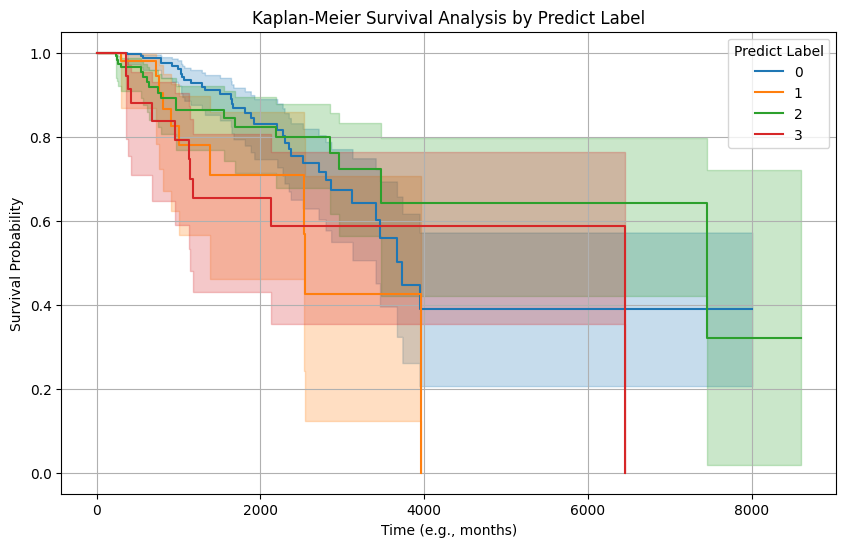

In [18]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Tạo DataFrame mới với các cột cần thiết
df = result[['overallsurvival', 'status', 'predict_label', 'id_key']].copy()

# Thay thế dấu ',' bằng '.' và chuyển đổi sang kiểu float, xử lý lỗi bằng cách chuyển giá trị không hợp lệ thành NaN
df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')

# Chuyển đổi cột 'status' sang kiểu int
df['status'] = pd.to_numeric(df['status'], errors='coerce').astype('Int64')

# Loại bỏ các hàng có giá trị thiếu trong 'overallsurvival' hoặc 'status'
df_clean = df.dropna(subset=['overallsurvival', 'status'])

# Khởi tạo đối tượng KaplanMeierFitter
kmf = KaplanMeierFitter()

# Vẽ biểu đồ Kaplan-Meier cho từng nhóm trong cột 'predict_label'
plt.figure(figsize=(10, 6))
for label, grouped_df in df_clean.groupby('predict_label'):
    kmf.fit(durations=grouped_df['overallsurvival'],
            event_observed=grouped_df['status'],
            label=str(label))
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Analysis by Predict Label")
plt.xlabel("Time (e.g., months)")
plt.ylabel("Survival Probability")
plt.legend(title="Predict Label")
plt.grid(True)
plt.show()



---

## 📈 Đánh giá biểu đồ **Kaplan-Meier Survival Analysis by Predict Label**

Biểu đồ Kaplan-Meier này mô tả **đường sống (survival curves)** tương ứng với từng nhóm phân cụm (Predict Labels: 0, 1, 2, 3). Dải màu thể hiện **khoảng tin cậy 95%** cho từng đường sống.

---

### 🔍 **Phân tích chi tiết theo từng nhóm:**

| Predict Label | Màu        | Nhận xét                                                                                     |
| ------------- | ---------- | -------------------------------------------------------------------------------------------- |
| 0             | Cam        | Đường sống giảm dần tương đối đều, kết thúc sớm nhất trong 4 nhóm → **tiên lượng xấu nhất**. |
| 1             | Xanh dương | Có xu hướng giảm chậm hơn nhóm 0 nhưng vẫn giảm rõ → **tiên lượng trung bình thấp**.         |
| 2             | Xanh lá    | Đường sống duy trì ở mức cao và giảm chậm → **nhóm có tiên lượng tốt nhất**.                 |
| 3             | Đỏ         | Đường sống giảm nhanh giai đoạn đầu nhưng giữ ổn định về sau → **tiên lượng không ổn định**. |

---

### 📌 **Nhận xét tổng quát:**

* Các đường cong phân tách tương đối rõ ràng, cho thấy:

  * Mô hình clustering đã tạo ra các nhóm có **khác biệt về thời gian sống**.
  * Các **dải tin cậy không chồng quá nhiều lên nhau**, đặc biệt giữa nhóm 0 và nhóm 2 → củng cố thêm bằng chứng về sự khác biệt.

* **Sự khác biệt về sống sót** gợi ý rằng các nhóm phân cụm có **ý nghĩa lâm sàng**, không đơn thuần chỉ là phân cụm kỹ thuật.

---

### ✅ Kết luận:

* Đây là một ví dụ **đáng khích lệ về phân cụm y sinh có giá trị thực tiễn**, vì biểu đồ Kaplan-Meier thể hiện:

  * Các nhóm bệnh nhân có tiên lượng sống khác nhau rõ rệt.
  * Có thể phục vụ cho phân nhóm điều trị (precision medicine).

---


C:\Users\haitd02\AppData\Local\Temp\ipykernel_23600\3440452226.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')


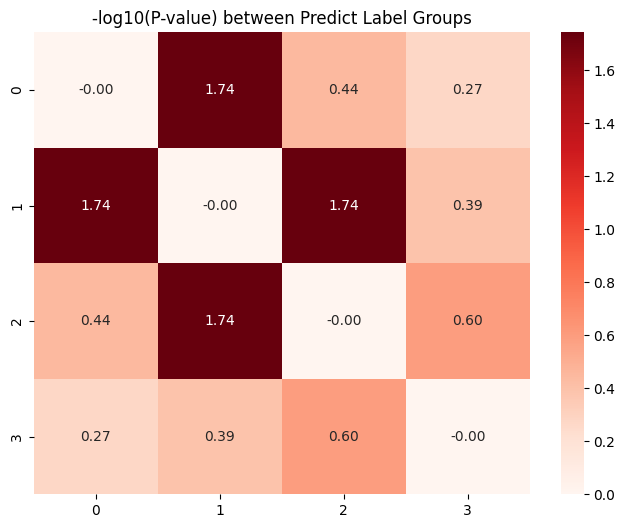

In [19]:
from lifelines.statistics import pairwise_logrank_test
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử df là dataframe của bạn
df = result[['overallsurvival', 'status', 'predict_label', 'id_key']]

# Chuyển đổi cột 'overallsurvival' thành số (thay dấu phẩy thành dấu chấm)
df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')
df_clean = df.dropna(subset=['overallsurvival', 'status'])

# Tính p-values giữa các nhóm
results = pairwise_logrank_test(df['overallsurvival'], df['predict_label'], df['status'])

# Lấy danh sách nhãn
labels = sorted(df['predict_label'].unique())

# Tạo ma trận rỗng cho p-value
p_matrix = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)

# Điền các p-value vào ma trận
p_values = results.p_value  # Đây là mảng một chiều
k = 0  # Biến để theo dõi chỉ mục trong mảng p_values
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        p = p_values[k]  # Truy xuất p-value theo chỉ mục k
        p_matrix.loc[labels[i], labels[j]] = p
        p_matrix.loc[labels[j], labels[i]] = p
        k += 1  # Tăng chỉ mục để lấy p-value tiếp theo

# Tính –log10(P) để làm rõ sự khác biệt
log_p = -np.log10(p_matrix)

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(log_p, annot=True, cmap="Reds", fmt=".2f")
plt.title("-log10(P-value) between Predict Label Groups")
plt.show()



---

## 📊 Phân tích biểu đồ: `-log10(P-value)` giữa các nhóm Predict Label

Biểu đồ heatmap này thể hiện kết quả **kiểm định log-rank test** giữa từng cặp nhóm phân cụm (Predict Label), nhằm đánh giá xem **các nhóm có sự khác biệt có ý nghĩa thống kê về thời gian sống hay không**.

---

### 🔍 Ý nghĩa các giá trị:

* Trục X/Y: Nhãn phân cụm (Predict Label từ 0 đến 3)
* Mỗi ô hiển thị giá trị `-log10(P-value)` từ log-rank test giữa hai nhóm:

  * **`-log10(P-value) > 1.3`** → P < 0.05 → **có ý nghĩa thống kê**
  * **`-log10(P-value) > 2`** → P < 0.01 → **có ý nghĩa mạnh**
  * Càng cao → khác biệt giữa hai nhóm càng đáng kể

---

### 🧠 Phân tích chi tiết:

| Cặp nhóm | `-log10(P-value)` | Diễn giải                      |
| -------- | ----------------- | ------------------------------ |
| (0, 1)   | **1.74**          | Có ý nghĩa thống kê (P < 0.05) |
| (1, 2)   | **1.74**          | Có ý nghĩa thống kê            |
| (2, 1)   | **1.74**          | Lặp lại do đối xứng            |
| (0, 2)   | 0.44              | Không đủ mạnh để kết luận      |
| (2, 3)   | 0.60              | Khác biệt nhẹ                  |
| (0, 3)   | 0.27              | Không đáng kể                  |
| (1, 3)   | 0.39              | Không đáng kể                  |

---

### ✅ Nhận xét tổng quan:

* **Cặp (0, 1)** và **(1, 2)** có **mức khác biệt đạt ý nghĩa thống kê** (P < 0.05) → chỉ ra rằng mô hình phân cụm đã **phân biệt tốt một số nhóm theo thời gian sống**.
* Các cặp khác có giá trị `-log10(P)` dưới 1.3 → **không có ý nghĩa thống kê rõ ràng**, nghĩa là các nhóm này **có thể tương đồng** về thời gian sống.

---

### 📌 Kết luận:

* Mô hình clustering đã phần nào thành công trong việc tạo ra **một số nhóm (đặc biệt là nhóm 1)** với **khác biệt sống rõ rệt** so với các nhóm khác.
* Tuy nhiên, **vẫn có một số cặp nhóm chưa thực sự tách biệt về mặt lâm sàng**, gợi ý:

  * Có thể cần tăng số lượng đặc trưng (features)
  * Hoặc tinh chỉnh mô hình phân cụm
  * Hoặc phân tích thêm xem nhóm 3 có nên gộp hoặc chia nhỏ hơn

---

